# Bangkok Air Quality Index (AQI) Forecast

## Objectives: 
Air quality in Thailand has recently been concerned, especially in many big cities such as Patumthani, Bangkok and Chiang Mai. As air pollution affects health, knowing how the air quality will be in advance can help people prepare to protect themselves. This project motivation is to forecast Bangkok AQI (only Din Daeng district) in order to estimate how air quality index will be in the next 2 days.

## Dataset
The dataset used in the prediction was from http://air4thai.pcd.go.th/webV2/history/ which derived by web-scraping. To calculate AQI, several factors are considered. According to AirNow, these factors include PM2.5, PM10, O3, CO, NO2 and SO2. The AQI index value is the maximum of AQI index of each pollutants at a time.

### Note:
According to AirNow, data for AQI calculation should be at least 3 digit. However, most of data that the source provided was rounded up. Some measurement stations are lack of data. For example, there are many stations that has only PM2.5 and PM10 values.

## Import libraries

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima

pd.set_option("display.max_rows", None)

In [216]:
df = pd.read_csv('report_54t_dindaeng.csv')

## Exploratory Data Analysis

In [217]:
df.head()

,No,date,time,PM2.5,PM10,O3,CO,NO2
0,1,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0
1,2,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0
2,3,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0
3,4,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0
4,5,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0


In [218]:
df.tail()

,No,date,time,PM2.5,PM10,O3,CO,NO2
859,860,2022-01-05,19:00 - 20:00,55,92,12.0,2.14,93.0
860,861,2022-01-05,20:00 - 21:00,56,98,4.0,2.65,107.0
861,862,2022-01-05,21:00 - 22:00,63,104,4.0,2.11,87.0
862,863,2022-01-05,22:00 - 23:00,59,110,2.0,1.85,74.0
863,864,2022-01-05,23:00 - 24:00,52,109,2.0,1.51,66.0


In [219]:
# drop the first column

df = df.drop(['No'], axis=1)
df.head()

,date,time,PM2.5,PM10,O3,CO,NO2
0,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0
1,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0
2,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0
3,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0
4,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0


In [220]:
df['time_'] = df['time'].str.split().str.get(0)
df.head()

,date,time,PM2.5,PM10,O3,CO,NO2,time_
0,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0,00:00
1,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0,01:00
2,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0,02:00
3,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0,03:00
4,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0,04:00


In [221]:
df['datetime'] = df['date'] + ' ' + df['time_'] + ':00'
df.head()

,date,time,PM2.5,PM10,O3,CO,NO2,time_,datetime
0,2021-12-01,00:00 - 01:00,32,79,18.0,1.28,32.0,00:00,2021-12-01 00:00:00
1,2021-12-01,01:00 - 02:00,27,78,19.0,1.23,29.0,01:00,2021-12-01 01:00:00
2,2021-12-01,02:00 - 03:00,25,74,21.0,1.22,25.0,02:00,2021-12-01 02:00:00
3,2021-12-01,03:00 - 04:00,33,72,30.0,1.15,18.0,03:00,2021-12-01 03:00:00
4,2021-12-01,04:00 - 05:00,40,66,19.0,1.23,26.0,04:00,2021-12-01 04:00:00


In [222]:
dd_pollutants = df[['datetime', 'PM2.5', 'PM10', 'O3', 'CO', 'NO2']]
dd_pollutants.head()

,datetime,PM2.5,PM10,O3,CO,NO2
0,2021-12-01 00:00:00,32,79,18.0,1.28,32.0
1,2021-12-01 01:00:00,27,78,19.0,1.23,29.0
2,2021-12-01 02:00:00,25,74,21.0,1.22,25.0
3,2021-12-01 03:00:00,33,72,30.0,1.15,18.0
4,2021-12-01 04:00:00,40,66,19.0,1.23,26.0


In [223]:
dd_pollutants.describe()

,PM2.5,PM10,O3,CO,NO2
count,864.000000,864.000000,747.000000,807.000000,807.000000
mean,40.590278,83.712963,13.859438,1.447794,44.022305
std,15.166857,26.332723,10.259779,0.529848,15.947168
min,12.000000,30.000000,1.000000,0.380000,10.000000
25%,30.000000,65.000000,5.000000,1.050000,32.000000
50%,37.000000,81.000000,11.000000,1.380000,43.000000
75%,49.000000,101.000000,21.000000,1.760000,55.000000
max,101.000000,174.000000,51.000000,3.720000,107.000000


In [224]:
dd_pollutants['datetime'] = pd.to_datetime(dd_pollutants["datetime"])
dd_pollutants.set_index('datetime', inplace=True)
dd_pollutants.index.freq = 'H'

/tmp/ipykernel_5329/2845609501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_pollutants['datetime'] = pd.to_datetime(dd_pollutants["datetime"])


In [225]:
dd_pollutants.head()

,PM2.5,PM10,O3,CO,NO2
datetime,,,,,
2021-12-01 00:00:00,32,79,18.0,1.28,32.0
2021-12-01 01:00:00,27,78,19.0,1.23,29.0
2021-12-01 02:00:00,25,74,21.0,1.22,25.0
2021-12-01 03:00:00,33,72,30.0,1.15,18.0
2021-12-01 04:00:00,40,66,19.0,1.23,26.0


In [226]:
dd_pollutants.index

DatetimeIndex(['2021-12-01 00:00:00', '2021-12-01 01:00:00',
               '2021-12-01 02:00:00', '2021-12-01 03:00:00',
               '2021-12-01 04:00:00', '2021-12-01 05:00:00',
               '2021-12-01 06:00:00', '2021-12-01 07:00:00',
               '2021-12-01 08:00:00', '2021-12-01 09:00:00',
               ...
               '2022-01-05 14:00:00', '2022-01-05 15:00:00',
               '2022-01-05 16:00:00', '2022-01-05 17:00:00',
               '2022-01-05 18:00:00', '2022-01-05 19:00:00',
               '2022-01-05 20:00:00', '2022-01-05 21:00:00',
               '2022-01-05 22:00:00', '2022-01-05 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=864, freq='H')

## Dealing with Missing Values

In [227]:
# check the number of missing values in each column
dd_pollutants.isna().sum()

PM2.5      0
PM10       0
O3       117
CO        57
NO2       57
dtype: int64

In [228]:
cleaned_pollutants = dd_pollutants.fillna(method='ffill')
cleaned_pollutants.isna().sum()

PM2.5    0
PM10     0
O3       0
CO       0
NO2      0
dtype: int64

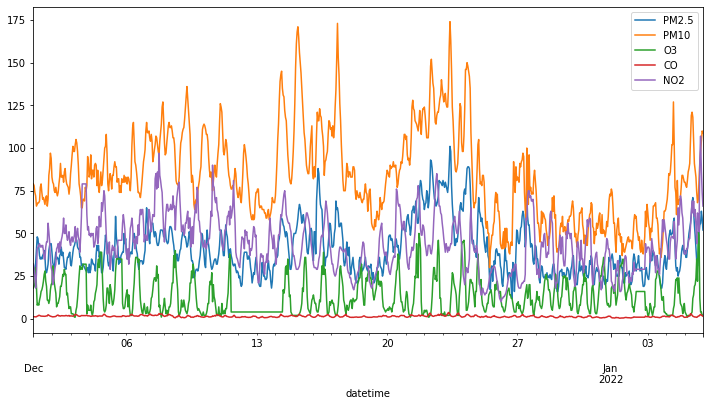

In [229]:
cleaned_pollutants.plot(figsize=(12,6));

In [230]:
cleaned_pollutants.describe()

,PM2.5,PM10,O3,CO,NO2
count,864.000000,864.000000,864.00000,864.000000,864.000000
mean,40.590278,83.712963,13.33912,1.444132,44.009259
std,15.166857,26.332723,10.28694,0.526993,15.944426
min,12.000000,30.000000,1.00000,0.380000,10.000000
25%,30.000000,65.000000,4.00000,1.030000,32.000000
50%,37.000000,81.000000,10.50000,1.380000,43.000000
75%,49.000000,101.000000,20.00000,1.760000,54.000000
max,101.000000,174.000000,51.00000,3.720000,107.000000


# Time Series Data Analysis

## ETS Decomposition
To learn more about error, trend and seasonality of each pollutant value, seasonal decomposition tool was used to detect any trend or seasonality.

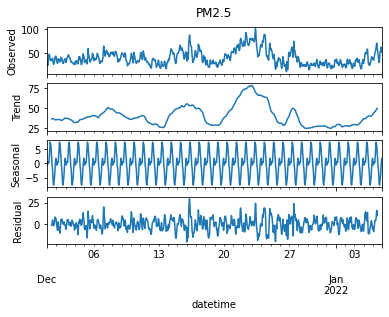

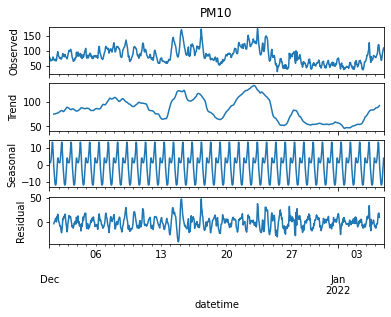

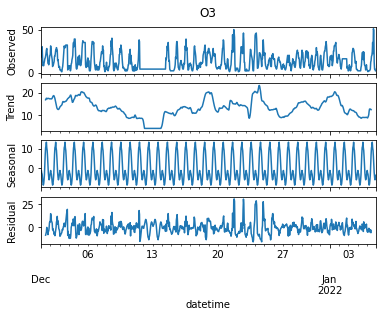

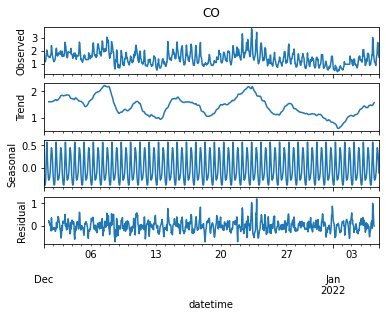

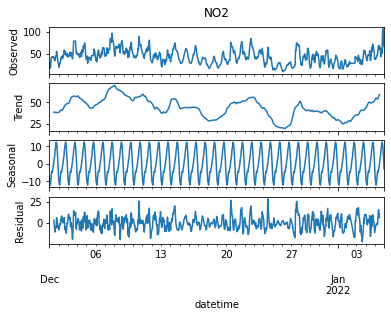

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose

columns = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

for col in columns:
    result = seasonal_decompose(cleaned_pollutants[col], model='add')
    
    fig, axes = plt.subplots(4, 1, sharex=True)
    result.observed.plot(ax=axes[0], legend=False)
    result.trend.plot(ax=axes[1], legend=False)
    result.seasonal.plot(ax=axes[2], legend=False)
    result.resid.plot(ax=axes[3], legend=False)
    plt.title(col,pad=180)
    axes[0].set_ylabel('Observed')
    axes[1].set_ylabel('Trend')
    axes[2].set_ylabel('Seasonal')
    axes[3].set_ylabel('Residual')
    
    plt.show()
    

From the seasonal decomposition, the changes of each pollutants had trend and seasonality.

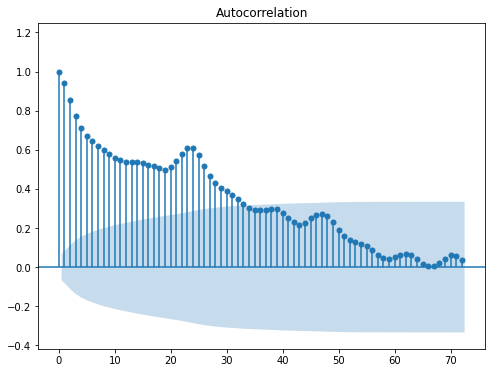

In [232]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

lags=24*3
fig, ax = plt.subplots(figsize=(8,6))
ax = plot_acf(cleaned_pollutants['PM2.5'], ax=ax, lags=lags, auto_ylims=True)


## Hypothesis Testing
To forecast, the data used should not have any trend or seasonality.  To ensure that these values were stationary, Augmented Dickey-Fuller Test was used to test.

In [233]:
# ADF test reporting function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [234]:
cleaned_pollutants.columns

Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2'], dtype='object')

In [235]:
features = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

for feature in features:
    adf_test(cleaned_pollutants[feature], title=feature)
    print("\n")

Augmented Dickey-Fuller Test: PM2.5
ADF test statistic       -1.742316
p-value                   0.409452
# lags used              21.000000
# observations          842.000000
critical value (1%)      -3.438140
critical value (5%)      -2.864979
critical value (10%)     -2.568601
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: PM10
ADF test statistic       -2.078250
p-value                   0.253350
# lags used              19.000000
# observations          844.000000
critical value (1%)      -3.438122
critical value (5%)      -2.864971
critical value (10%)     -2.568597
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: O3
ADF test statistic       -3.293522
p-value                   0.015171
# lags used              21.000000
# observations          842.000000
critical value (1%)   

Most pollutants values were non-stationary. Therefore, the data would be transformed by differencing until every pollutants are staionary.

## Differencing : 1 

In [236]:
transformed = cleaned_pollutants.diff().dropna()
for feature in features:
    adf_test(transformed_pollutants[feature], title=feature)
    print("\n")

Augmented Dickey-Fuller Test: PM2.5
ADF test statistic     -1.208465e+01
p-value                 2.191726e-22
# lags used             2.000000e+01
# observations          8.420000e+02
critical value (1%)    -3.438140e+00
critical value (5%)    -2.864979e+00
critical value (10%)   -2.568601e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: PM10
ADF test statistic     -1.132782e+01
p-value                 1.132012e-20
# lags used             1.800000e+01
# observations          8.440000e+02
critical value (1%)    -3.438122e+00
critical value (5%)    -2.864971e+00
critical value (10%)   -2.568597e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: O3
ADF test statistic     -1.573555e+01
p-value                 1.274089e-28
# lags used             2.100000e+01
# observations          8.410000e+02
crit

# Training data with VAR model
To train the data for prediction, the model VAR was selected as these pollutant indicators may affect each other.

## Train Test Split Data
As this project's objective is to forecast AQI index in the next 5 days, the test dataset was the latest 120 data points (24 hours x 5 days).

In [237]:
test_len = 5*24
train = transformed.iloc[:-test_len]
test = transformed.iloc[-test_len:]

In [238]:
train.shape

(743, 5)

In [239]:
test.shape

(120, 5)

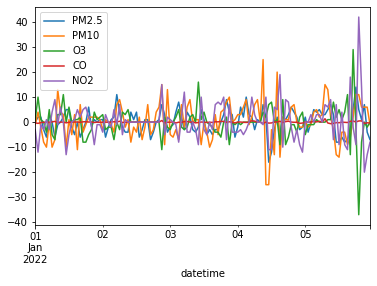

In [252]:
test.plot();

In [240]:
# create a model and find the proper order for the model
var_model = VAR(train)
for i in range(1,16):
    results = var_model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  10.83000447615329
BIC:  11.016366305391864

Order = 2
AIC:  10.75432168577856
BIC:  11.096346023688525

Order = 3
AIC:  10.70267705608926
BIC:  11.200693292435014

Order = 4
AIC:  10.576902920220483
BIC:  11.231241596403923

Order = 5
AIC:  10.519328809568444
BIC:  11.330321624199964

Order = 6
AIC:  10.493226960063831
BIC:  11.461206774567694

Order = 7
AIC:  10.459427501325646
BIC:  11.58472834557999

Order = 8
AIC:  10.443519675320962
BIC:  11.726476753332706

Order = 9
AIC:  10.400843599940098
BIC:  11.841793295555

Order = 10
AIC:  10.360815755330915
BIC:  11.960095637979068

Order = 11
AIC:  10.352532520129053
BIC:  12.110481350606058

Order = 12
AIC:  10.345411239183356
BIC:  12.262368975467464

Order = 13
AIC:  10.341725720441918
BIC:  12.418033523547404

Order = 14
AIC:  10.351971012242837
BIC:  12.58797125210988

Order = 15
AIC:  10.381390595266744
BIC:  12.777426856688091



In [241]:
var_model.endog_names

['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

In [268]:
result = var_model.fit(1)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jan, 2022
Time:                     14:17:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    11.0164
Nobs:                     742.000    HQIC:                   10.9018
Log likelihood:          -9252.19    FPE:                    50514.0
AIC:                      10.8300    Det(Omega_mle):         48520.3
--------------------------------------------------------------------
Results for equation PM2.5
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.010202         0.182375            0.056           0.955
L1.PM2.5         0.144230         0.038809            3.716           0.000
L1.PM10          0.125856         0.027835            4.522           0.000
L1.O

In [269]:
lag_order = result.k_ar
lag_order

1

## Forecast 

In [270]:
z = result.forecast(y=train.values[-lag_order:], steps=test_len)
z

array([[ 8.95747753e-01,  1.04912591e+00, -8.94145909e-01,
         2.62870529e-02, -5.18880892e-01],
       [ 3.68486629e-01,  6.33094797e-01, -2.50725328e-01,
         5.39199608e-03, -2.69511116e-01],
       [ 1.65083163e-01,  2.47548028e-01, -8.59856034e-02,
         3.91378317e-04, -1.15708785e-01],
       [ 6.70725815e-02,  8.31223761e-02, -3.69907286e-02,
        -9.64556708e-05, -4.34428224e-02],
       [ 2.98406496e-02,  2.37431409e-02, -2.31454761e-02,
         1.61137817e-04, -1.09255135e-02],
       [ 1.76958919e-02,  5.42289659e-03, -1.91896834e-02,
         3.59147015e-04,  2.13944481e-03],
       [ 1.42722165e-02,  5.79788426e-04, -1.80057936e-02,
         4.44314140e-04,  6.84164138e-03],
       [ 1.34487631e-02, -4.85701687e-04, -1.76243574e-02,
         4.72005929e-04,  8.36694769e-03],
       [ 1.32868772e-02, -6.65081572e-04, -1.74928368e-02,
         4.78963764e-04,  8.81504656e-03],
       [ 1.32632627e-02, -6.82727393e-04, -1.74458847e-02,
         4.80118672e-04

In [271]:
test

,PM2.5,PM10,O3,CO,NO2
datetime,,,,,
2022-01-01 00:00:00,0.0,-1.0,1.0,-0.30,-3.0
2022-01-01 01:00:00,2.0,4.0,10.0,-0.49,-12.0
2022-01-01 02:00:00,2.0,-2.0,1.0,-0.19,-1.0
2022-01-01 03:00:00,-3.0,-8.0,0.0,-0.07,-3.0
2022-01-01 04:00:00,-6.0,-10.0,-4.0,0.04,1.0
2022-01-01 05:00:00,3.0,0.0,5.0,-0.10,-3.0
2022-01-01 06:00:00,0.0,-10.0,-5.0,0.10,4.0
2022-01-01 07:00:00,-6.0,-7.0,-7.0,0.30,9.0
2022-01-01 08:00:00,-1.0,13.0,3.0,-0.19,-1.0


In [272]:
idx = pd.date_range('2022-01-01 00:00:00', periods=test_len, freq='H')
df_forecast = pd.DataFrame(z, index=idx, columns=['PM2.5_1d', 'PM10_1d', 'O3_1d', 'CO_1d', 'NO2_1d'])
df_forecast

,PM2.5_1d,PM10_1d,O3_1d,CO_1d,NO2_1d
2022-01-01 00:00:00,0.895748,1.049126,-0.894146,0.026287,-0.518881
2022-01-01 01:00:00,0.368487,0.633095,-0.250725,0.005392,-0.269511
2022-01-01 02:00:00,0.165083,0.247548,-0.085986,0.000391,-0.115709
2022-01-01 03:00:00,0.067073,0.083122,-0.036991,-0.000096,-0.043443
2022-01-01 04:00:00,0.029841,0.023743,-0.023145,0.000161,-0.010926
2022-01-01 05:00:00,0.017696,0.005423,-0.019190,0.000359,0.002139
2022-01-01 06:00:00,0.014272,0.000580,-0.018006,0.000444,0.006842
2022-01-01 07:00:00,0.013449,-0.000486,-0.017624,0.000472,0.008367
2022-01-01 08:00:00,0.013287,-0.000665,-0.017493,0.000479,0.008815
2022-01-01 09:00:00,0.013263,-0.000683,-0.017446,0.000480,0.008935


## Invert the Transformation

In [273]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
for col in columns:
    df_forecast[col+'_forecast'] = cleaned_pollutants[col].iloc[-test_len-1]-df_forecast[col+'_1d'].cumsum()


In [274]:
df_forecast.head()

,PM2.5_1d,PM10_1d,O3_1d,CO_1d,NO2_1d,PM2.5_forecast,PM10_forecast,O3_forecast,CO_forecast,NO2_forecast
2022-01-01 00:00:00,0.895748,1.049126,-0.894146,0.026287,-0.518881,33.104252,71.950874,7.894146,1.553713,37.518881
2022-01-01 01:00:00,0.368487,0.633095,-0.250725,0.005392,-0.269511,32.735766,71.317779,8.144871,1.548321,37.788392
2022-01-01 02:00:00,0.165083,0.247548,-0.085986,0.000391,-0.115709,32.570682,71.070231,8.230857,1.547930,37.904101
2022-01-01 03:00:00,0.067073,0.083122,-0.036991,-0.000096,-0.043443,32.503610,70.987109,8.267848,1.548026,37.947544
2022-01-01 04:00:00,0.029841,0.023743,-0.023145,0.000161,-0.010926,32.473769,70.963366,8.290993,1.547865,37.958469


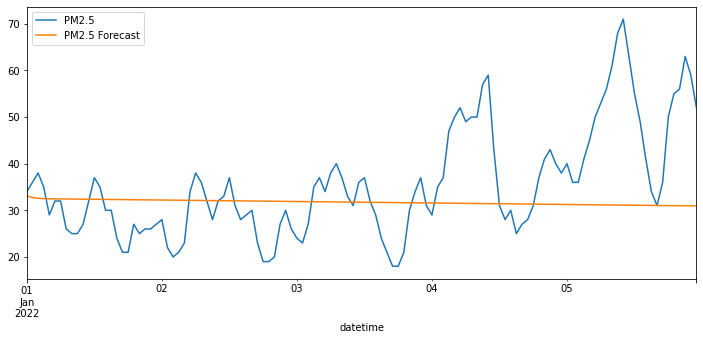

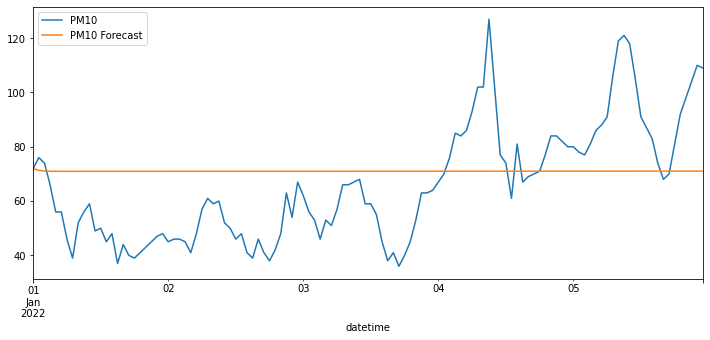

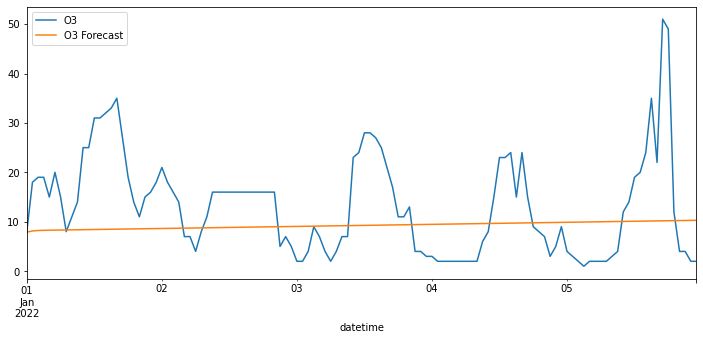

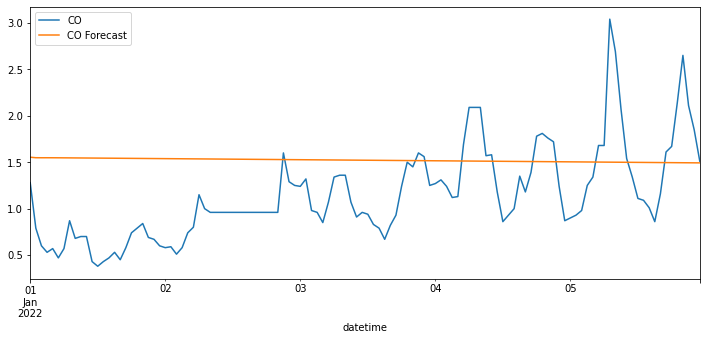

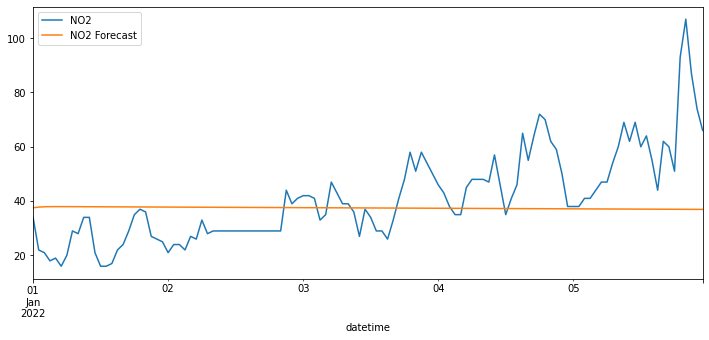

In [275]:
# plot the test data vs prediction
for col in columns:
    plt.figure(figsize=(12,5))
    cleaned_pollutants[col][-test_len:].plot(figsize=(12,5),legend=True, label=col);
    df_forecast[col+'_forecast'].plot(legend=True, label= col + " Forecast");

# Evaluating Model

In [276]:
for col in columns:
    print("RMSE VAR(1) for " + col + ": " + str(rmse(cleaned_pollutants[col][-test_len:], df_forecast[col+'_forecast'])))


RMSE VAR(1) for PM2.5: 12.491309954074355
RMSE VAR(1) for PM10: 22.097047152620814
RMSE VAR(1) for O3: 10.97513686475139
RMSE VAR(1) for CO: 0.6318190561530623
RMSE VAR(1) for NO2: 17.200816861989537


## Compare results to individual AR(1)

In [257]:
from statsmodels.tsa.ar_model import AutoReg,ARResults

### PM2.5

In [279]:
model25 = AutoReg(train['PM2.5'], lags=1)
AR1fit1 = model25.fit()
print(f'Lag: {AR1fit1.ar_lags}')
print(f'Coefficients:\n{AR1fit1.params}')

Lag: [1]
Coefficients:
const       0.008219
PM2.5.L1    0.225338
dtype: float64


In [280]:
start=len(train)
end=len(train)+len(test)-1
z1 = pd.DataFrame(AR1fit1.predict(start=start, end=end, dynamic=False),columns=['PM2.5'])

In [281]:
z1

,PM2.5
2022-01-01 00:00:00,-0.442456
2022-01-01 01:00:00,-0.091483
2022-01-01 02:00:00,-0.012395
2022-01-01 03:00:00,0.005426
2022-01-01 04:00:00,0.009442
2022-01-01 05:00:00,0.010347
2022-01-01 06:00:00,0.010551
2022-01-01 07:00:00,0.010597
2022-01-01 08:00:00,0.010607
2022-01-01 09:00:00,0.010609


In [283]:
# Now build the forecast values from the first difference set
z1['PM2.5_forecast'] = cleaned_pollutants['PM2.5'].iloc[-test_len-1] + z1['PM2.5'].cumsum()

In [284]:
rmse_ar_pm25 = rmse(cleaned_pollutants['PM2.5'][-test_len:], z1['PM2.5_forecast'])

print(f'PM2.5  AR(1) RMSE: {rmse_ar_pm25:.3f}')

PM2.5  AR(1) RMSE: 11.499


In [287]:
components =['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

for component in components:
    model = AutoReg(train[component], lags=1).fit()
    start=len(train)
    end=len(train)+len(test)-1
    z = pd.DataFrame(model.predict(start=start, end=end, dynamic=False),columns=[component])
    # Inversion
    z[component+'_forecast'] = cleaned_pollutants[component].iloc[-test_len-1] + z[component].cumsum()
    rmse_var = rmse(cleaned_pollutants[component][-test_len:], df_forecast[component+'_forecast'])
    rmse_ar = rmse(cleaned_pollutants[component][-test_len:], z[component+'_forecast'])
    print('{component}, VAR(1) RMSE: {rmse_var} '.format(component=component, rmse_var=rmse_var))
    print('{component}, AR(1) RMSE: {rmse_ar} '.format(component=component, rmse_ar=rmse_ar))
    print('\n')
    
    

PM2.5, VAR(1) RMSE: 12.491309954074355 
PM2.5, AR(1) RMSE: 11.499478140568872 


PM10, VAR(1) RMSE: 22.097047152620814 
PM10, AR(1) RMSE: 23.202198702852574 


O3, VAR(1) RMSE: 10.97513686475139 
O3, AR(1) RMSE: 12.314347406251384 


CO, VAR(1) RMSE: 0.6318190561530623 
CO, AR(1) RMSE: 0.6993851082723933 


NO2, VAR(1) RMSE: 17.200816861989537 
NO2, AR(1) RMSE: 16.836943735121416 


